# Time series of key diagnostics of the THAI simulations


In [1]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [2]:
# Data analysis and viz libraries
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.offsetbox import AnchoredText

# Progress bar
from tqdm.notebook import tqdm

In [3]:
import aeolus.plot as aplt

In [4]:
# Local modules
import mypaths
from calc import get_time_rel_days, time_mean
from commons import MODELS
from names import names
from plot_func import KW_AUX_TTL, KW_MAIN_TTL, KW_SBPLT_LABEL, figsave

In [5]:
plt.style.use("paper.mplstyle")


Bad key legend.labelcolor in file paper.mplstyle, line 10 ('legend.labelcolor : linecolor')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution


## Choose cases

In [6]:
THAI_cases = ["Hab1"]  # , "Hab2"]

## Load the data

Load the data previously preprocessed: time mean and standard deviation.

In [7]:
# Load data
datasets = {}  # Create an empty dictionary to store all data
# for each of the THAI cases, create a nested directory for models
for THAI_case in THAI_cases:
    datasets[THAI_case] = {}
    for model_key in MODELS.keys():
        datasets[THAI_case][model_key] = xr.open_dataset(
            mypaths.datadir / model_key / f"{THAI_case}_time_series_{model_key}.nc"
        )

In [8]:
# SIMULATION LENGTH [Earth days]
ndays = 610

In [9]:
datasets[THAI_case][model_key]

<xarray.Dataset>
Dimensions:            (time: 2440)
Coordinates:
  * time               (time) float64 8.64e+04 8.641e+04 ... 1.01e+05 1.01e+05
Data variables: (12/16)
    t_sfc_g            (time) float32 ...
    t_sfc_d            (time) float32 ...
    t_sfc_n            (time) float32 ...
    t_sfc_t            (time) float32 ...
    ocean_frac_g       (time) float32 ...
    ocean_frac_d       (time) float32 ...
    ...                 ...
    cwp_n              (time) float32 ...
    cwp_t              (time) float32 ...
    alt_cld_mmr_max_g  (time) float32 ...
    alt_cld_mmr_max_d  (time) float32 ...
    alt_cld_mmr_max_n  (time) float32 ...
    alt_cld_mmr_max_t  (time) float32 ...

## Choose case

In [10]:
AGGR_TITLES = {
    "g": "Global",
    "d": "Day side",
    "n": "Night side",
    "t": "Terminators",
}

In [11]:
VAR_PLOT = {
    "t_sfc": {
        "title": "Surface\ntemperature [$K$]",
        "lim": {
            "Hab1": dict(g=[230, 255], d=[258, 272], n=[200, 240]),
            "Hab2": dict(g=[265, 300], d=[280, 305], n=[255, 290]),
        },
    },
    "ocean_frac": {
        "title": "Ice-free ocean\narea fraction",
        "lim": {"Hab1": dict(g=[0.18, 0.25]), "Hab2": dict(g=[0.3, 1.1])},
    },
    "cwp": {
        "title": "Cloud water\npath [$kg$ $m^{-2}$]",
        "lim": {
            "Hab1": dict(g=[0.02, 0.18], d=[0.04, 0.30], n=[0, 0.12], t=[0, 0.18]),
            "Hab2": dict(g=[0.02, 0.3], d=[0.04, 0.4], n=[0, 0.25], t=[0, 0.25]),
        },
    },
    "alt_cld_mmr_max": {
        "title": "Altitude of the cloud\nMMR maximum [$km$]",
        "lim": {
            "Hab1": dict(g=[0, 12], d=[0, 12], n=[0, 12], t=[0, 12]),
            "Hab2": dict(g=[0, 15], d=[0, 15], n=[0, 15], t=[0, 15]),
        },
    },
}

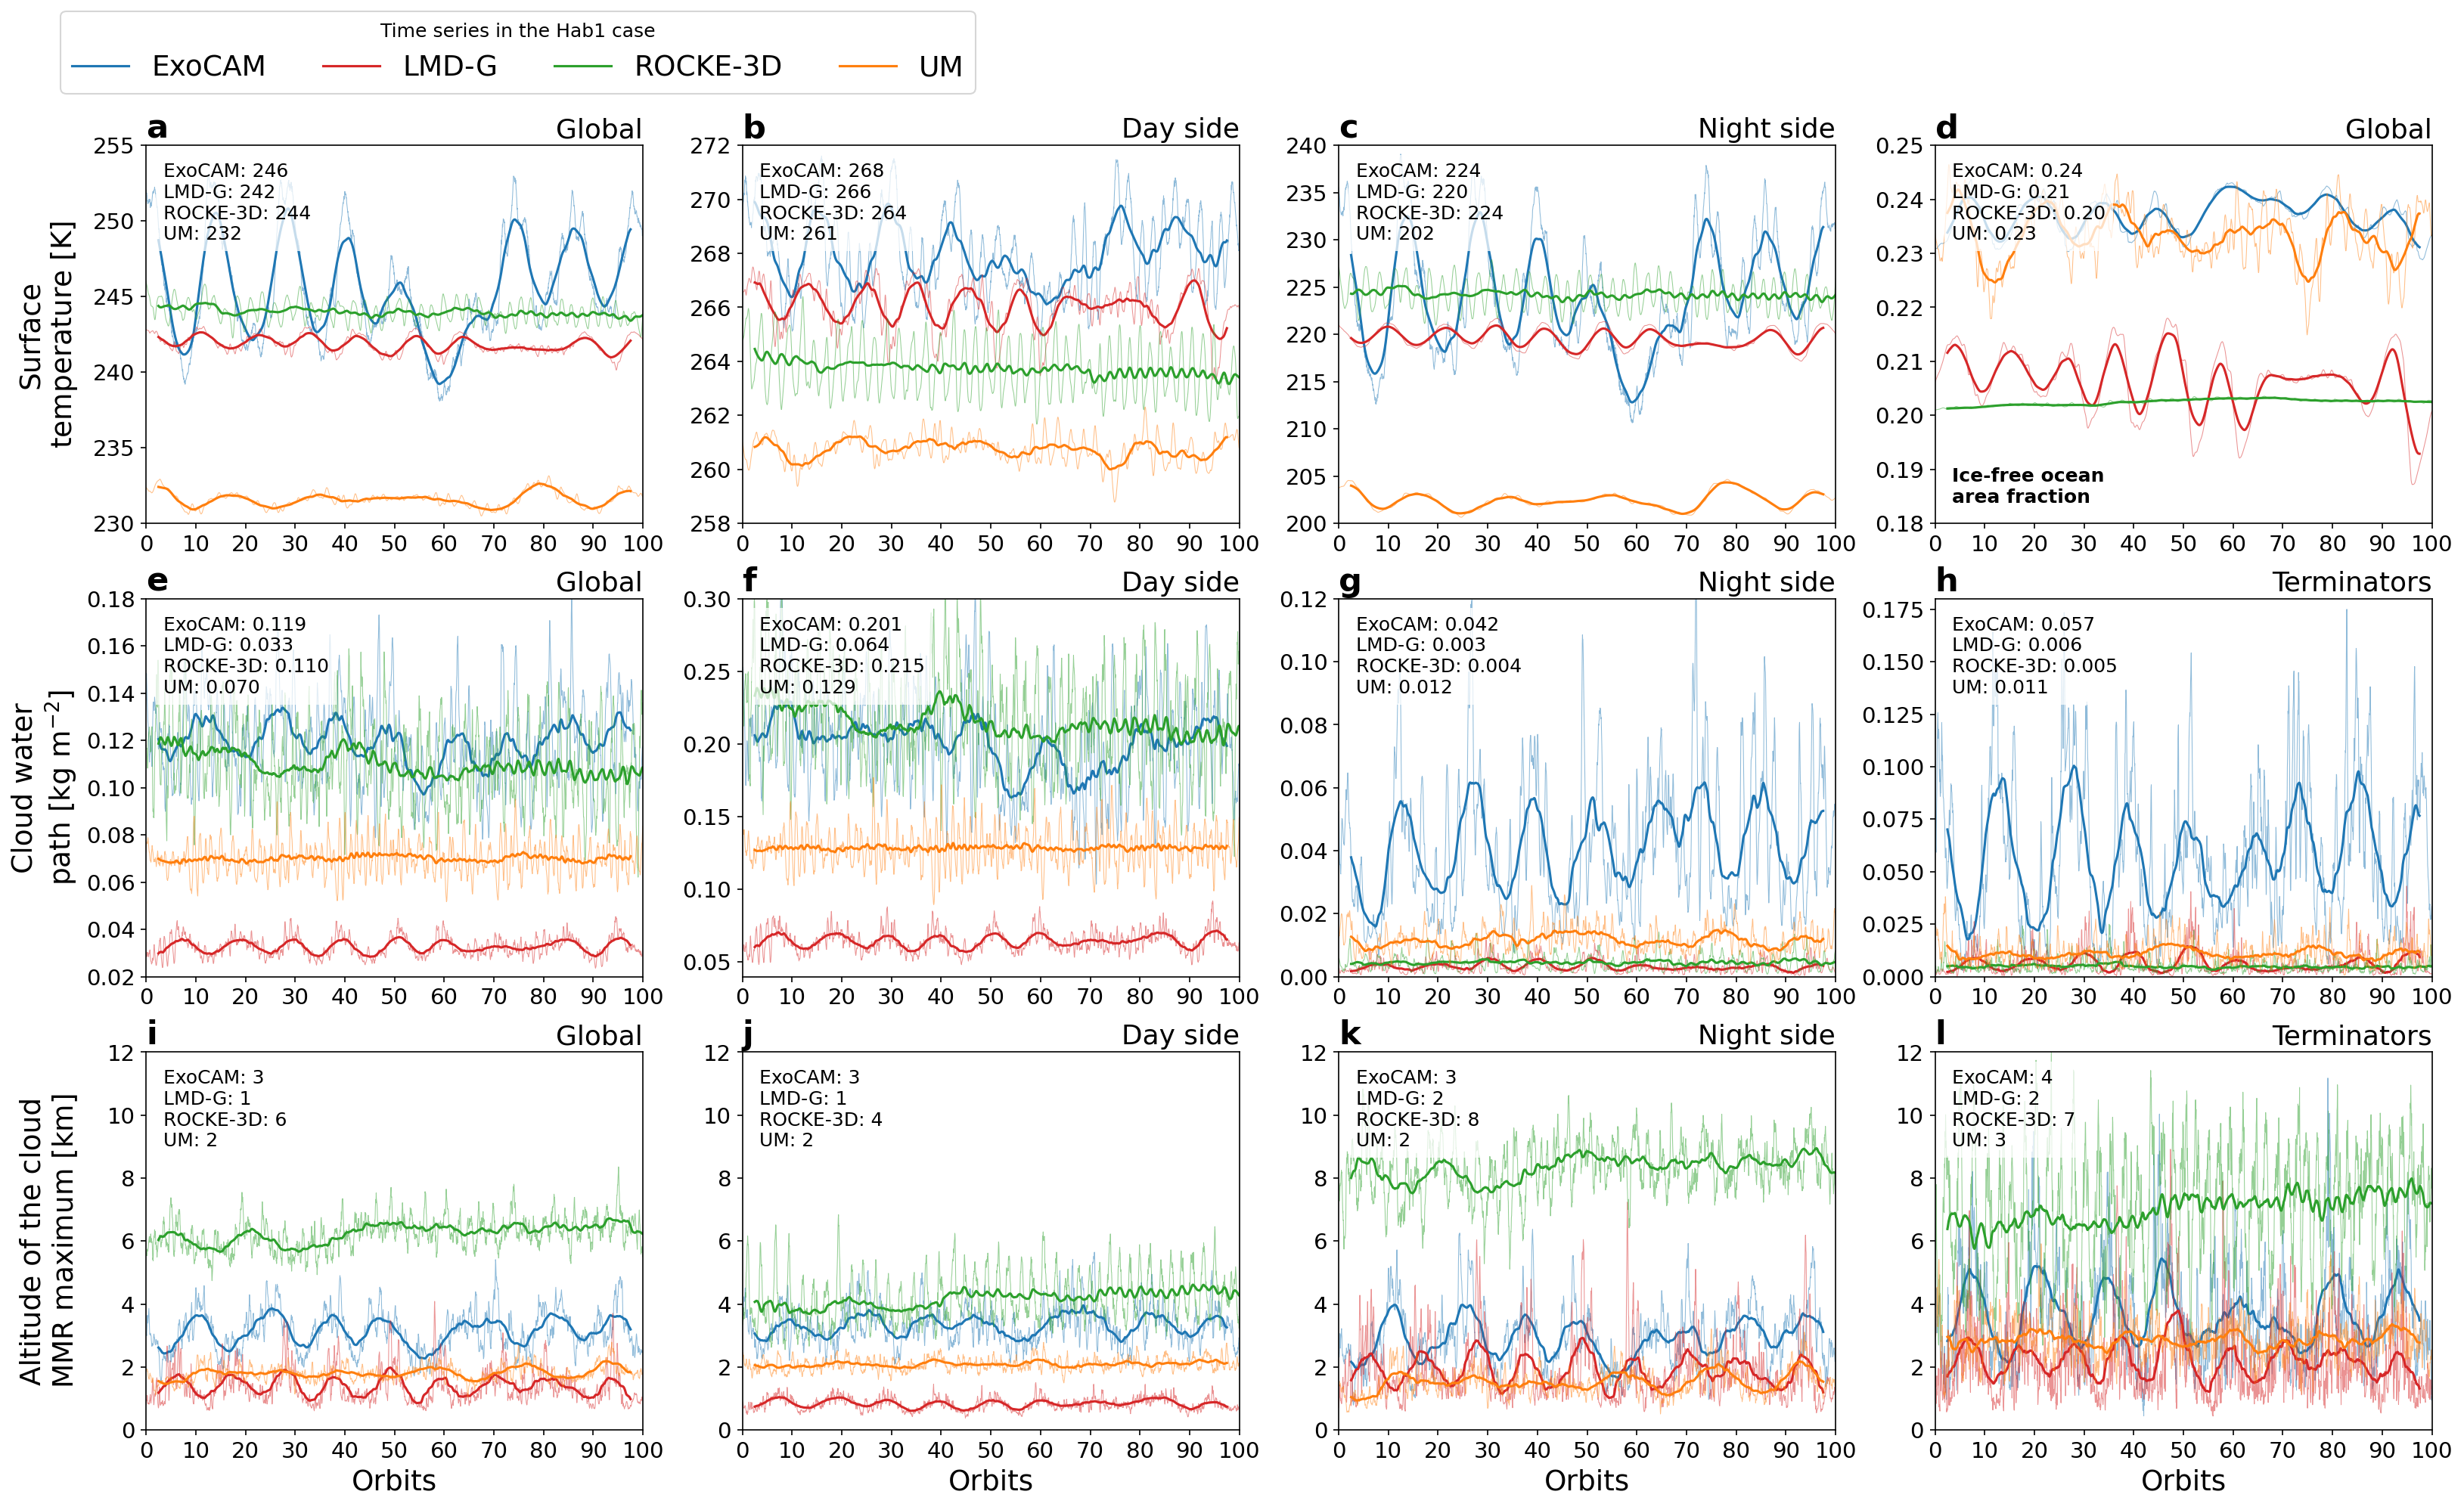

In [12]:
use_roll_mean = True
ncols = 4
nrows = 3  # len(VAR_PLOT)
rolling_window = 122  # 4 x 6.1 x 5 = 5 TRAPPIST-1e days

THAI_case = "Hab1"
if THAI_case.endswith("1"):
    import const_ben1_hab1 as const
else:
    import const_ben2_hab2 as const

fig, axs = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(6.5 * ncols, 5 * nrows), constrained_layout=False
)
iletters = aplt.subplot_label_generator()
# Surface temperature
ax_slice = axs[0, :-1]
var_key = "t_sfc"
var_dict = VAR_PLOT[var_key]
for ax, (aggr_key, aggr_title) in zip(ax_slice, AGGR_TITLES.items()):
    t_mean_str = {}
    for model_key, model_dict in MODELS.items():
        model_names = names[model_key]
        data = datasets[THAI_case][model_key][f"{var_key}_{aggr_key}"]
        time = np.arange(data.shape[0]) / 4
        t_mean_str[model_dict["title"]] = time_mean(data, time_name=model_names.t)
        if use_roll_mean:
            ax.plot(time, data, color=model_dict["color"], linewidth=0.5, alpha=0.5)
            ax.plot(
                time,
                data.rolling(**{model_names.t: rolling_window}, center=True).mean(),
                color=model_dict["color"],
                linewidth=1.5,
                label=model_dict["title"],
            )
        else:
            ax.plot(
                time,
                data,
                color=model_dict["color"],
                linewidth=1.0,
                label=model_dict["title"],
            )
    t_mean_str = "\n".join([f"{k}: {round(float(v.values)):.0f}" for k, v in t_mean_str.items()])
    at = AnchoredText(t_mean_str, loc="upper left")
    at.patch.set_facecolor((1, 1, 1, 0.75))
    at.patch.set_edgecolor("none")
    ax.add_artist(at)
    ax.set_ylim(var_dict["lim"][THAI_case][aggr_key])
    if ax.is_first_col():
        ax.set_ylabel(var_dict["title"])
    ax.set_title(aggr_title, **KW_AUX_TTL)

# Ocean fraction (global only)
var_key = "ocean_frac"
var_dict = VAR_PLOT[var_key]
aggr_key = "g"
ax = axs[0, -1]
t_mean_str = {}
for model_key, model_dict in MODELS.items():
    model_names = names[model_key]
    data = datasets[THAI_case][model_key][f"{var_key}_{aggr_key}"]
    time = np.arange(data.shape[0]) / 4
    t_mean_str[model_dict["title"]] = time_mean(data, time_name=model_names.t)
    if use_roll_mean:
        ax.plot(time, data, color=model_dict["color"], linewidth=0.5, alpha=0.5)
        ax.plot(
            time,
            data.rolling(**{model_names.t: rolling_window}, center=True).mean(),
            color=model_dict["color"],
            linewidth=1.5,
            label=model_dict["title"],
        )
    else:
        ax.plot(
            time,
            data,
            color=model_dict["color"],
            linewidth=1.0,
            label=model_dict["title"],
        )
t_mean_str = "\n".join([f"{k}: {float(v.values):.2f}" for k, v in t_mean_str.items()])
at = AnchoredText(t_mean_str, loc="upper left")
at.patch.set_facecolor((1, 1, 1, 0.75))
at.patch.set_edgecolor("none")
ax.add_artist(at)
at = AnchoredText(var_dict["title"], loc="lower left", prop=dict(fontweight="bold"))
at.patch.set_facecolor((1, 1, 1, 0.75))
at.patch.set_edgecolor("none")
ax.add_artist(at)
# ax.set_title(var_dict["title"], **KW_MAIN_TTL)
ax.set_ylim(var_dict["lim"][THAI_case][aggr_key])
ax.set_title(AGGR_TITLES[aggr_key], **KW_AUX_TTL)

# The rest: CWP and cloud height
for ax_slice, var_key in zip(axs[1:, :], ["cwp", "alt_cld_mmr_max"]):
    var_dict = VAR_PLOT[var_key]
    if var_key == "alt_cld_mmr_max":
        factor = 1 / const.kilo
    else:
        factor = 1
    for ax, (aggr_key, aggr_title) in zip(ax_slice, AGGR_TITLES.items()):
        t_mean_str = {}
        for model_key, model_dict in MODELS.items():
            model_names = names[model_key]
            data = datasets[THAI_case][model_key][f"{var_key}_{aggr_key}"]
            data = data.copy() * factor
            time = np.arange(data.shape[0]) / 4
            t_mean_str[model_dict["title"]] = time_mean(data, time_name=model_names.t)
            if use_roll_mean:
                ax.plot(time, data, color=model_dict["color"], linewidth=0.5, alpha=0.5)
                ax.plot(
                    time,
                    data.rolling(**{model_names.t: rolling_window}, center=True).mean(),
                    color=model_dict["color"],
                    linewidth=1.5,
                    label=model_dict["title"],
                )
            else:
                ax.plot(
                    time,
                    data,
                    color=model_dict["color"],
                    linewidth=1.0,
                    label=model_dict["title"],
                )
        if var_key == "cwp":
            t_mean_str = "\n".join([f"{k}: {float(v.values):.3f}" for k, v in t_mean_str.items()])
        else:
            t_mean_str = "\n".join(
                [f"{k}: {round(float(v.values)):.0f}" for k, v in t_mean_str.items()]
            )
        at = AnchoredText(t_mean_str, loc="upper left")
        at.patch.set_facecolor((1, 1, 1, 0.75))
        at.patch.set_edgecolor("none")
        ax.add_artist(at)
        ax.set_ylim(var_dict["lim"][THAI_case][aggr_key])
        if ax.is_first_col():
            ax.set_ylabel(var_dict["title"])
        ax.set_title(AGGR_TITLES[aggr_key], **KW_AUX_TTL)

# Common labels
for ax in axs.flat:
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
    ax.set_xlim(0, ndays)
    ax.set_xticks(np.linspace(0, ndays, 11))
    ax.set_xticklabels(np.round(np.linspace(0, ndays, 11) / const.period).astype(int))
    if ax.is_last_row():
        ax.set_xlabel("Orbits")

ttl = f"Time series in the {THAI_case} case"
axs.flatten()[0].legend(title=ttl, ncol=len(MODELS), loc="lower left", bbox_to_anchor=(-0.2, 1.1))
fig.align_ylabels(axs[:, 0])
# plt.subplots_adjust(wspace=0.3)

In [13]:
figsave(
    fig,
    mypaths.plotdir / f"{THAI_case}__tseries__{'_'.join(VAR_PLOT.keys())}__roll_mean",
)

Saved to ../plots/Hab1__tseries__t_sfc_ocean_frac_cwp_alt_cld_mmr_max__roll_mean.png
